In [133]:
# # import packages and authenticate (if needed)
# import numpy as np
# import tidy3d as td
# import tidy3d.web as web
# from matplotlib import pyplot as plt
# from tidy3d.plugins import waveguide
# from tidy3d.plugins.mode.web import run as run_mode_solver

# import tidy3d as td
# from tidy3d.plugins import waveguide
# import matplotlib.pyplot as plt

# import matplotlib.pylab as plt
# import numpy as np
# import tidy3d as td
# import tidy3d.web as web
#
# web.configure("U7IS5Q1AW3qYVxPAAQDE7vgxaTz6Kt6aI9AioPZUajVRQQ2o")

In [134]:
# # Media used in the examples
# si = td.material_library["cSi"]["Li1993_293K"]
# sio2 = td.material_library["SiO2"]["Horiba"]

In [135]:
# fig, ax = pyplot.subplots(1,1, figsize=(10, 4), tight_layout=True)
#
# undercut = strip = waveguide.RectangularDielectric(
#     wavelength=1.55,
#     core_width=0.5,
#     core_thickness=0.22,
#     sidewall_angle=-0,
#     core_medium=si,
#     clad_medium=td.Medium(permittivity=1.0),
#     box_medium=sio2
# )
#
# undercut.plot_structures(x=0, ax=ax)
# ax.set_title("Uncladded undercut channel")

19:29:14 Hora est. Pacífico, Sudamérica WARNING: 'filter_pol' is deprecated and 
                                        will be removed in future versions.     
                                        Please use 'sort_spec' instead.         

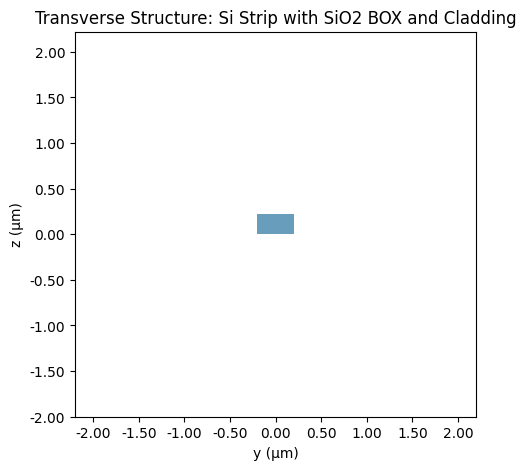

                                        WARNING: 'filter_pol' is deprecated and 
                                        will be removed in future versions.     
                                        Please use 'sort_spec' instead.         

                                        WARNING: 'filter_pol' is deprecated and 
                                        will be removed in future versions.     
                                        Please use 'sort_spec' instead.         

                                        WARNING: 'filter_pol' is deprecated and 
                                        will be removed in future versions.     
                                        Please use 'sort_spec' instead.         

D:\GitHub\GDS_py_TDY_venv\.venv\Lib\site-packages\scipy\sparse\_construct.py:543: FutureWarning: Input has data type int64, but the output has been cast to float64.  In the future, the output data type will match the input. To avoid this warning, set the `dtype` parameter to `None` to have the output dtype match the input, or set it to the desired output data type.
Note: In Python 3.11, this warning can be generated by a call of scipy.sparse.diags(), but the code indicated in the warning message will refer to an internal call of scipy.sparse.diags_array(). If that happens, check your code for the use of diags().
  A = diags_array(diagonals, offsets=offsets, shape=shape, dtype=dtype)


19:29:15 Hora est. Pacífico, Sudamérica WARNING: 'filter_pol' is deprecated and 
                                        will be removed in future versions.     
                                        Please use 'sort_spec' instead.         

                                        WARNING: 'filter_pol' is deprecated and 
                                        will be removed in future versions.     
                                        Please use 'sort_spec' instead.         

                                        WARNING: Mode field at frequency index  
                                        0, mode index 1 does not decay at the   
                                        plane boundaries.                       

                                        WARNING: Mode field at frequency index  
                                        0, mode index 2 does not decay at the   
                                        plane boundaries.                       

                                        WARNING: 'filter_pol' is deprecated and 
                                        will be removed in future versions.     
                                        Please use 'sort_spec' instead.         

                                        WARNING: 'filter_pol' is deprecated and 
                                        will be removed in future versions.     
                                        Please use 'sort_spec' instead.         

                                        WARNING: 'filter_pol' is deprecated and 
                                        will be removed in future versions.     
                                        Please use 'sort_spec' instead.         

                                        WARNING: 'filter_pol' is deprecated and 
                                        will be removed in future versions.     
                                        Please use 'sort_spec' instead.         

19:29:16 Hora est. Pacífico, Sudamérica WARNING: 'filter_pol' is deprecated and 
                                        will be removed in future versions.     
                                        Please use 'sort_spec' instead.         

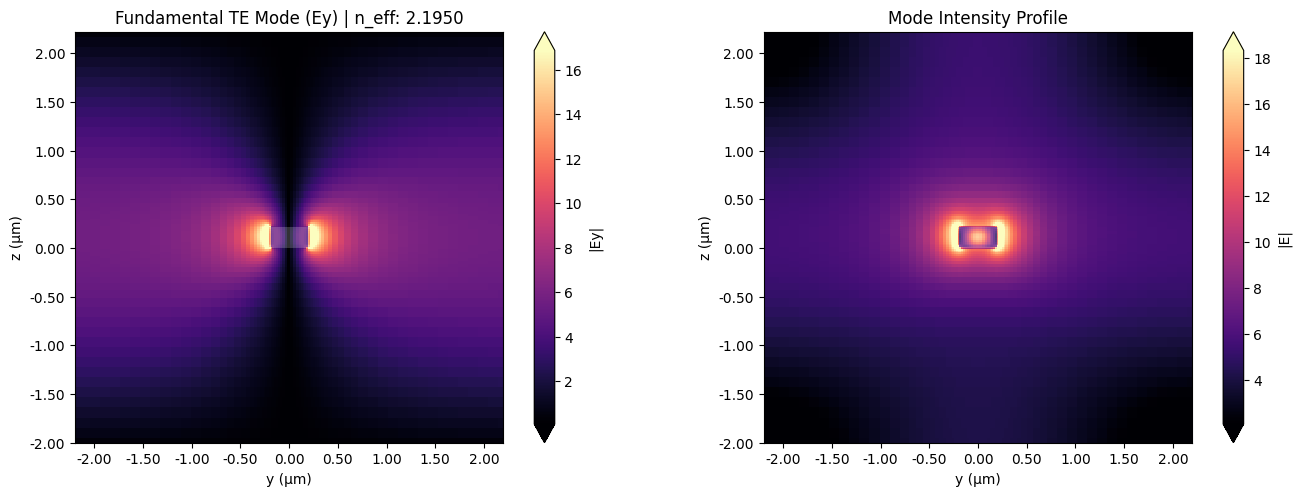

Mode 0: n_eff = 2.1950
Mode 1: n_eff = 1.4339
Mode 2: n_eff = 1.4269
Mode 3: n_eff = 1.6831


<xarray.DataArray 'te' (f: 1, mode_index: 4)> Size: 32B
array([[0.95801692, 0.58808973, 0.99999751, 0.04832478]])
Coordinates:
  * f           (f) float64 8B 1.934e+14
  * mode_index  (mode_index) int64 32B 0 1 2 3

In [137]:
# # Wavelength
# wavelength = 1.55  # microns
#
# # Geometry parameters (microns)
# core_thickness = 0.22     # 220 nm
# core_width = 0.48         # 480 nm
#
# # Define waveguide
# wg = waveguide.RectangularDielectric(
#     wavelength=wavelength,
#     core_width=core_width,
#     core_thickness=core_thickness,
#     core_medium=si,
#     clad_medium=sio2,
#     box_medium=sio2,
#     box_thickness=2.0,
#     grid_resolution=25,
# )
#
# wg.plot_structures()
#
# mode_data = wg.mode_solver.solve()
#
# print("n_eff:", mode_data.n_eff.values)


import numpy as np
import matplotlib.pyplot as plt
import tidy3d as td
from tidy3d.plugins import waveguide

# --- 1. Material Definitions ---
# Using fixed indices for 1550nm for simplicity
n_si = 3.48
n_sio2 = 1.444

mat_si = td.Medium(permittivity=n_si**2)
mat_sio2 = td.Medium(permittivity=n_sio2**2)

# --- 2. Create Waveguide using the Plugin ---
# clad_medium covers the top and lateral sides
# box_medium covers the bottom silica layer
strip_waveguide = waveguide.RectangularDielectric(
    wavelength=1.55,
    core_width=0.400,
    core_thickness=0.22,
    core_medium=mat_si,
    clad_medium=mat_sio2,
    box_medium=mat_sio2,
    clad_thickness=2.0,  # Vertical extent of cladding
    box_thickness=2.0,   # Vertical extent of BOX
    side_margin=2.0,     # Lateral extent of cladding
    mode_spec=td.ModeSpec(num_modes=4, target_neff=n_si, filter_pol="te")
)

# --- 3. Structure Visualization ---
# We plot the cross-section to verify materials and dimensions
fig, ax = plt.subplots(1, 1, figsize=(8, 5))
strip_waveguide.plot_structures(x=0, ax=ax)
plt.title("Transverse Structure: Si Strip with SiO2 BOX and Cladding")
plt.show()

# --- 4. Mode Solving ---
# The plugin has a built-in property to access its own mode solver
mode_data = strip_waveguide.mode_solver.solve()



# --- 5. Plotting Results for TE Light ---
# Mode index 0 is typically the fundamental Quasi-TE mode
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

# Plot Ey field (dominant component for TE in this orientation)
strip_waveguide.plot_field("Ey", "abs", mode_index=1, ax=axs[0])
axs[0].set_title(f"Fundamental TE Mode (Ey) | n_eff: {float(mode_data.n_eff.values[0][0]):.4f}")

# Plot E-field absolute intensity
strip_waveguide.plot_field("E", "abs", mode_index=1, ax=axs[1])
axs[1].set_title("Mode Intensity Profile")

plt.tight_layout()
plt.show()

# Print out the effective indices for all solved modes
for i, neff in enumerate(mode_data.n_eff.values[0]):
    print(f"Mode {i}: n_eff = {neff:.4f}")


mode_data.pol_fraction['te']